In [32]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import xml.etree.ElementTree as ET
from collections import Counter
import warnings
from tqdm import tqdm
from pathlib import Path
import torch
from ultralytics import YOLO

warnings.filterwarnings('ignore')

#style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [33]:
!pip install ultralytics==8.0.196


In [34]:
# Define paths
COCO_PATH = "/kaggle/input/coco-image-caption"
ROAD_SIGN_PATH = "/kaggle/input/road-sign-detection"

# COCO annotation files
COCO_TRAIN_ANN = os.path.join(COCO_PATH, "annotations_trainval2014/annotations/captions_train2014.json")
COCO_VAL_ANN = os.path.join(COCO_PATH, "annotations_trainval2014/annotations/captions_val2014.json")
COCO_INSTANCES_TRAIN = os.path.join(COCO_PATH, "annotations_trainval2014/annotations/instances_train2014.json")

# Load COCO captions
with open(COCO_TRAIN_ANN, 'r') as f:
    coco_train_captions = json.load(f)

with open(COCO_VAL_ANN, 'r') as f:
    coco_val_captions = json.load(f)

with open(COCO_INSTANCES_TRAIN, 'r') as f:
    coco_instances = json.load(f)

print("COCO annotations loaded successfully!")

COCO annotations loaded successfully!


In [35]:
# Explore COCO structure
print("COCO DATASET STRUCTURE")

print("\n1. Caption Dataset Keys:")
print(f"   Train: {coco_train_captions.keys()}")
print(f"   Val: {coco_val_captions.keys()}")

print("\n2. Number of Images:")
print(f"   Train: {len(coco_train_captions['images']):,}")
print(f"   Val: {len(coco_val_captions['images']):,}")
print(f"   Total: {len(coco_train_captions['images']) + len(coco_val_captions['images']):,}")

print("\n3. Number of Captions:")
print(f"   Train: {len(coco_train_captions['annotations']):,}")
print(f"   Val: {len(coco_val_captions['annotations']):,}")
print(f"   Total: {len(coco_train_captions['annotations']) + len(coco_val_captions['annotations']):,}")

print("\n4. Number of Object Categories:")
print(f"   Total Classes: {len(coco_instances['categories'])}")

COCO DATASET STRUCTURE

1. Caption Dataset Keys:
   Train: dict_keys(['info', 'images', 'licenses', 'annotations'])
   Val: dict_keys(['info', 'images', 'licenses', 'annotations'])

2. Number of Images:
   Train: 82,783
   Val: 40,504
   Total: 123,287

3. Number of Captions:
   Train: 414,113
   Val: 202,654
   Total: 616,767

4. Number of Object Categories:
   Total Classes: 80


In [36]:
# Create DataFrames for easier analysis
print("Creating COCO DataFrames")

# Images DataFrame
coco_images_train = pd.DataFrame(coco_train_captions['images'])
coco_images_val = pd.DataFrame(coco_val_captions['images'])
coco_images = pd.concat([coco_images_train, coco_images_val], ignore_index=True)

# Captions DataFrame
coco_captions_train = pd.DataFrame(coco_train_captions['annotations'])
coco_captions_val = pd.DataFrame(coco_val_captions['annotations'])
coco_captions = pd.concat([coco_captions_train, coco_captions_val], ignore_index=True)

# Categories DataFrame
coco_categories = pd.DataFrame(coco_instances['categories'])

# Object instances DataFrame
coco_objects = pd.DataFrame(coco_instances['annotations'])

print("DataFrames created")
print(f"\nCOCO Images shape: {coco_images.shape}")
print(f"COCO Captions shape: {coco_captions.shape}")
print(f"COCO Categories shape: {coco_categories.shape}")
print(f"COCO Objects shape: {coco_objects.shape}")

Creating COCO DataFrames
DataFrames created

COCO Images shape: (123287, 8)
COCO Captions shape: (616767, 3)
COCO Categories shape: (80, 3)
COCO Objects shape: (604907, 7)


In [37]:
# Analyze captions
print("COCO CAPTION ANALYSIS")

# Caption length analysis
coco_captions['caption_length'] = coco_captions['caption'].str.split().str.len()

print(f"\n1. Caption Length Statistics:")
print(f"   Mean: {coco_captions['caption_length'].mean():.2f} words")
print(f"   Median: {coco_captions['caption_length'].median():.0f} words")
print(f"   Min: {coco_captions['caption_length'].min()} words")
print(f"   Max: {coco_captions['caption_length'].max()} words")
print(f"   Std: {coco_captions['caption_length'].std():.2f} words")

# Captions per image
captions_per_image = coco_captions.groupby('image_id').size()
print(f"\n2. Captions per Image:")
print(f"   Average: {captions_per_image.mean():.2f}")
print(f"   Most images have: {captions_per_image.mode()[0]} captions")

# Sample captions
print("\n3. Sample Captions:")
for i, row in coco_captions.sample(5).iterrows():
    print(f"   • {row['caption']}")

COCO CAPTION ANALYSIS

1. Caption Length Statistics:
   Mean: 10.46 words
   Median: 10 words
   Min: 5 words
   Max: 50 words
   Std: 2.39 words

2. Captions per Image:
   Average: 5.00
   Most images have: 5 captions

3. Sample Captions:
   • A man covers his ears with his hands as he stands outside a store
   • Female tennis player during mid swing on court.
   • A multi colored parrot sitting on a rope.
   • Silhouette of several animals off in the distance at dusk time
   • A man holding a blue camera in front of his face.


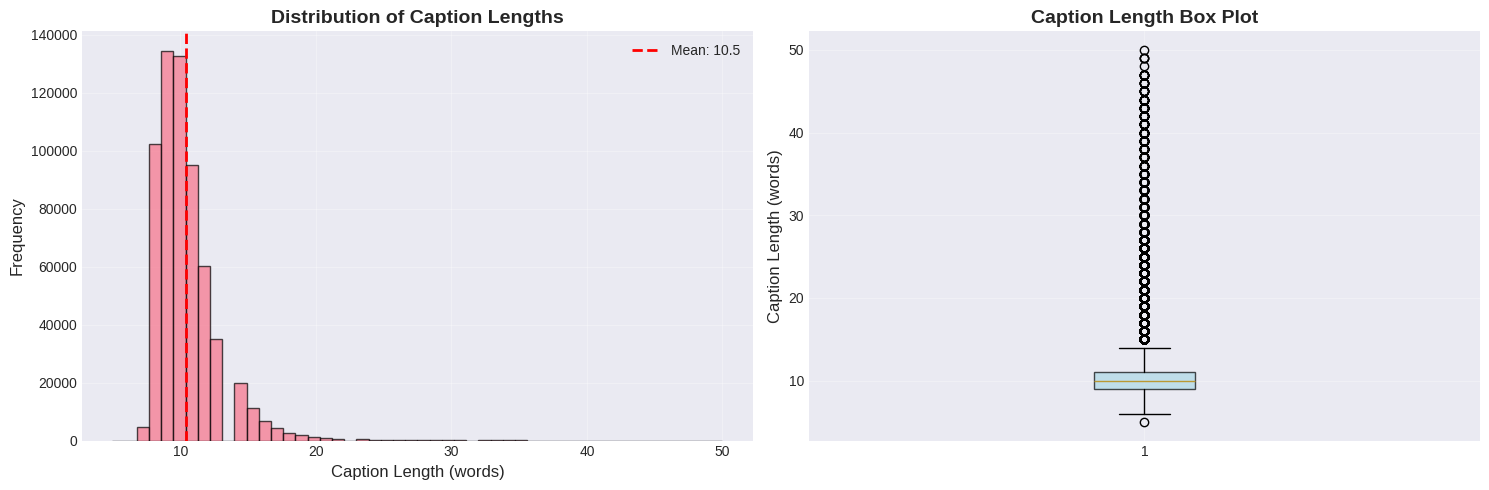

In [38]:
# Visualize caption lengths
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(coco_captions['caption_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(coco_captions['caption_length'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f'Mean: {coco_captions["caption_length"].mean():.1f}')
axes[0].set_xlabel('Caption Length (words)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Caption Lengths', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
axes[1].boxplot(coco_captions['caption_length'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[1].set_ylabel('Caption Length (words)', fontsize=12)
axes[1].set_title('Caption Length Box Plot', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [39]:
# Analyze image dimensions
print("COCO IMAGE DIMENSIONS ANALYSIS")

print(f"\n1. Resolution Statistics:")
print(f"   Width  - Mean: {coco_images['width'].mean():.0f}px, Min: {coco_images['width'].min()}px, Max: {coco_images['width'].max()}px")
print(f"   Height - Mean: {coco_images['height'].mean():.0f}px, Min: {coco_images['height'].min()}px, Max: {coco_images['height'].max()}px")

# Calculate aspect ratios
coco_images['aspect_ratio'] = coco_images['width'] / coco_images['height']
print(f"\n2. Aspect Ratio Statistics:")
print(f"   Mean: {coco_images['aspect_ratio'].mean():.2f}")
print(f"   Median: {coco_images['aspect_ratio'].median():.2f}")

# Categorize image sizes
coco_images['size_category'] = pd.cut(coco_images['width'], 
                                       bins=[0, 640, 1280, 1920, 10000],
                                       labels=['Small (<640)', 'Medium (640-1280)', 
                                              'Large (1280-1920)', 'Very Large (>1920)'])

print(f"\n3. Image Size Distribution:")
print(coco_images['size_category'].value_counts().sort_index())

COCO IMAGE DIMENSIONS ANALYSIS

1. Resolution Statistics:
   Width  - Mean: 578px, Min: 59px, Max: 640px
   Height - Mean: 484px, Min: 51px, Max: 640px

2. Aspect Ratio Statistics:
   Mean: 1.25
   Median: 1.33

3. Image Size Distribution:
size_category
Small (<640)          123287
Medium (640-1280)          0
Large (1280-1920)          0
Very Large (>1920)         0
Name: count, dtype: int64


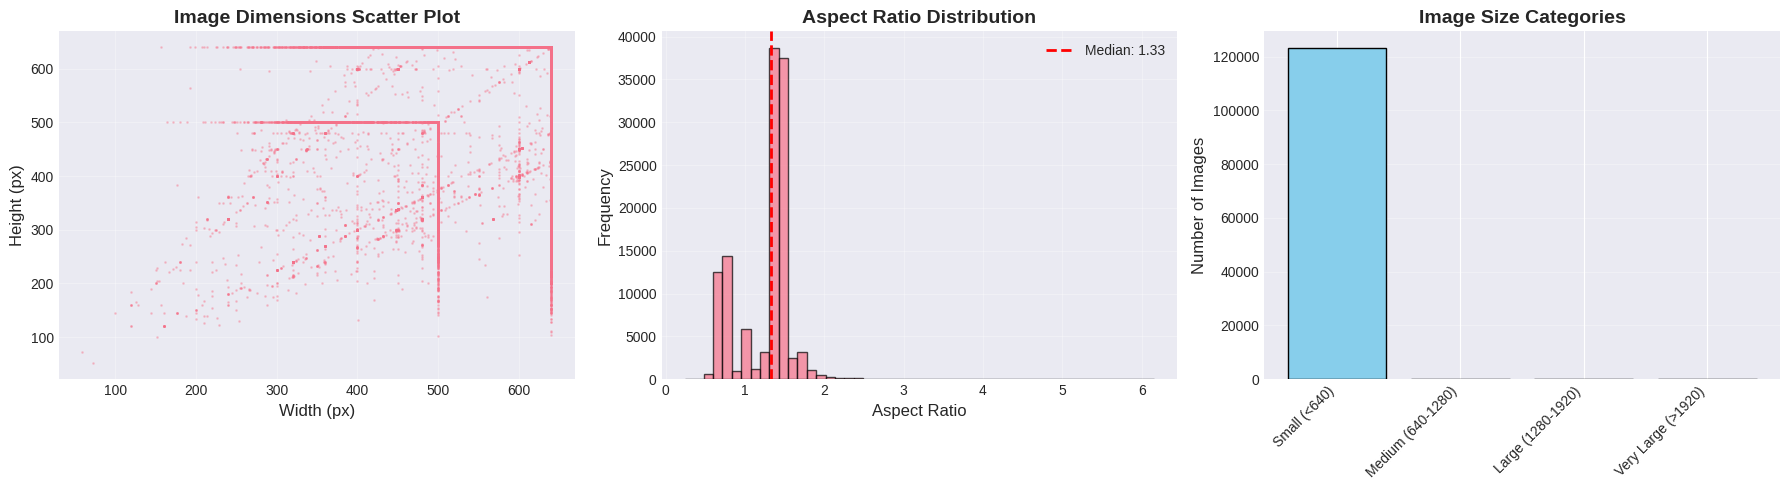

In [40]:
# Visualize image dimensions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Width vs Height scatter
axes[0].scatter(coco_images['width'], coco_images['height'], alpha=0.3, s=1)
axes[0].set_xlabel('Width (px)', fontsize=12)
axes[0].set_ylabel('Height (px)', fontsize=12)
axes[0].set_title('Image Dimensions Scatter Plot', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Aspect ratio distribution
axes[1].hist(coco_images['aspect_ratio'], bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(coco_images['aspect_ratio'].median(), color='red', 
                linestyle='--', linewidth=2, label=f'Median: {coco_images["aspect_ratio"].median():.2f}')
axes[1].set_xlabel('Aspect Ratio', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Aspect Ratio Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Size category bar chart
size_counts = coco_images['size_category'].value_counts().sort_index()
axes[2].bar(range(len(size_counts)), size_counts.values, color='skyblue', edgecolor='black')
axes[2].set_xticks(range(len(size_counts)))
axes[2].set_xticklabels(size_counts.index, rotation=45, ha='right')
axes[2].set_ylabel('Number of Images', fontsize=12)
axes[2].set_title('Image Size Categories', fontsize=14, fontweight='bold')
axes[2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [41]:
# Analyze object categories
print("COCO OBJECT CATEGORIES ANALYSIS")

print(f"\n1. Total Object Categories: {len(coco_categories)}")

print("\n2. All Categories:")
print(coco_categories[['id', 'name', 'supercategory']].to_string(index=False))

# Count objects per category
category_counts = coco_objects['category_id'].value_counts()
category_names = coco_categories.set_index('id')['name'].to_dict()
category_counts_named = pd.Series({category_names[k]: v for k, v in category_counts.items()})

print("\n3. Top 10 Most Common Objects:")
for i, (cat, count) in enumerate(category_counts_named.head(10).items(), 1):
    print(f"   {i:2d}. {cat:20s}: {count:,} instances")

COCO OBJECT CATEGORIES ANALYSIS

1. Total Object Categories: 80

2. All Categories:
 id           name supercategory
  1         person        person
  2        bicycle       vehicle
  3            car       vehicle
  4     motorcycle       vehicle
  5       airplane       vehicle
  6            bus       vehicle
  7          train       vehicle
  8          truck       vehicle
  9           boat       vehicle
 10  traffic light       outdoor
 11   fire hydrant       outdoor
 13      stop sign       outdoor
 14  parking meter       outdoor
 15          bench       outdoor
 16           bird        animal
 17            cat        animal
 18            dog        animal
 19          horse        animal
 20          sheep        animal
 21            cow        animal
 22       elephant        animal
 23           bear        animal
 24          zebra        animal
 25        giraffe        animal
 27       backpack     accessory
 28       umbrella     accessory
 31        handbag     ac

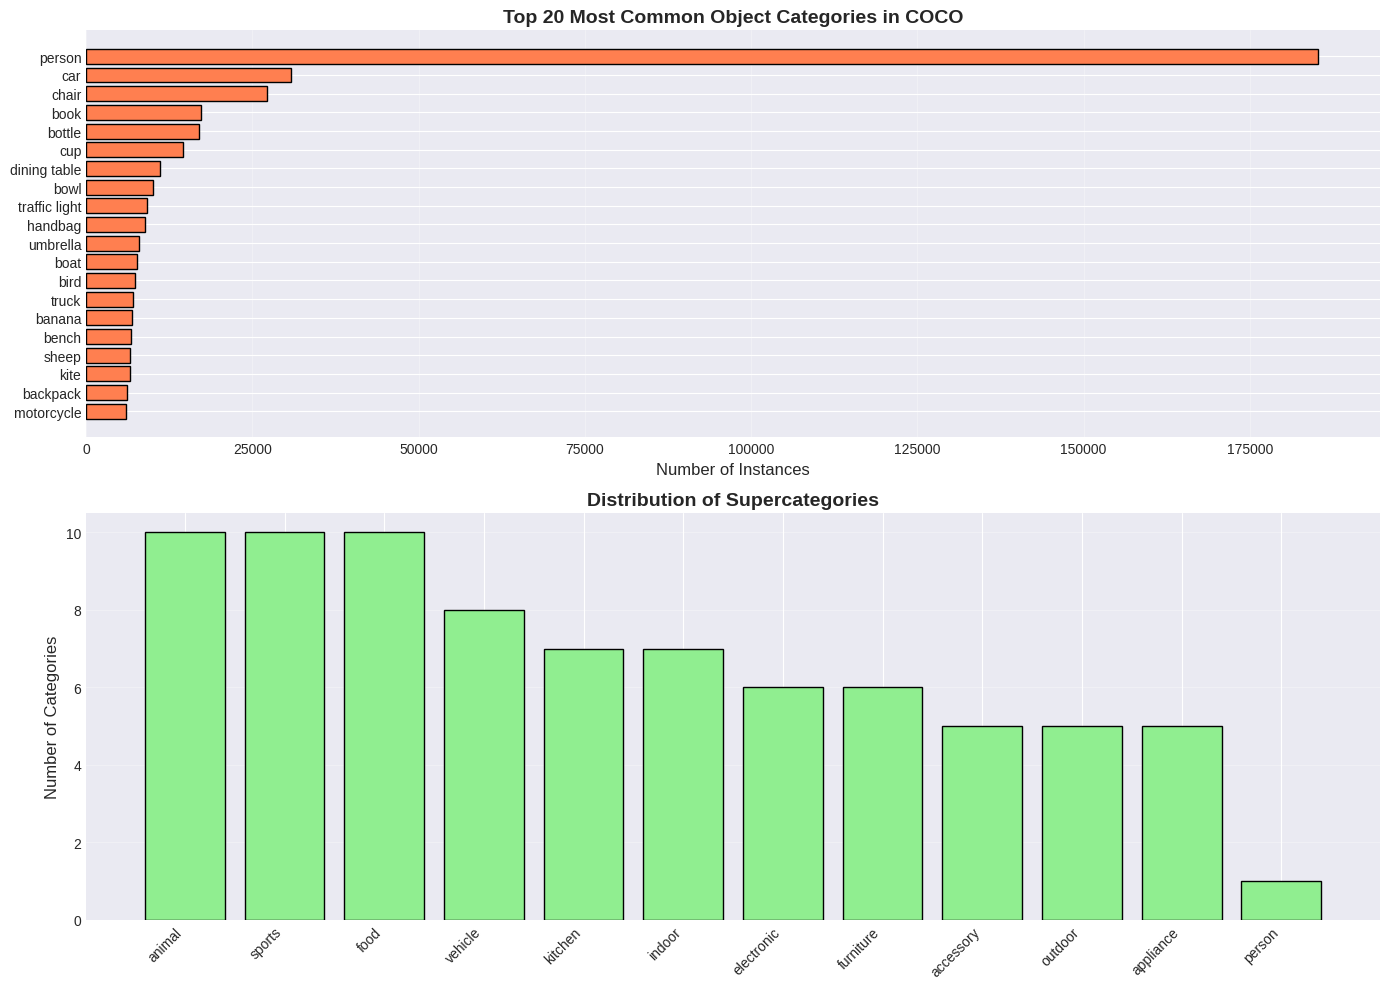

In [42]:
# Visualize top object categories
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Top 20 categories
top_20 = category_counts_named.head(20)
axes[0].barh(range(len(top_20)), top_20.values, color='coral', edgecolor='black')
axes[0].set_yticks(range(len(top_20)))
axes[0].set_yticklabels(top_20.index)
axes[0].set_xlabel('Number of Instances', fontsize=12)
axes[0].set_title('Top 20 Most Common Object Categories in COCO', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(alpha=0.3, axis='x')

# Supercategory distribution
supercategory_counts = coco_categories['supercategory'].value_counts()
axes[1].bar(range(len(supercategory_counts)), supercategory_counts.values, 
            color='lightgreen', edgecolor='black')
axes[1].set_xticks(range(len(supercategory_counts)))
axes[1].set_xticklabels(supercategory_counts.index, rotation=45, ha='right')
axes[1].set_ylabel('Number of Categories', fontsize=12)
axes[1].set_title('Distribution of Supercategories', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [43]:
# Define relevant classes for assistive navigation system
ASSISTIVE_CLASSES = [
    'person', 'bicycle', 'car', 'motorcycle', 'bus', 'truck',
    'traffic light', 'stop sign', 'bench', 'chair', 'couch',
    'potted plant', 'dining table', 'tv', 'laptop', 'cell phone',
    'book', 'clock', 'bottle', 'cup', 'fork', 'knife', 'spoon', 'bowl'
]

print("RELEVANT CLASSES FOR ASSISTIVE SYSTEM")

# Get category IDs for relevant classes
relevant_categories = coco_categories[coco_categories['name'].isin(ASSISTIVE_CLASSES)]
relevant_category_ids = relevant_categories['id'].tolist()

print(f"\n1. Selected Classes ({len(ASSISTIVE_CLASSES)}):")
for i, cls in enumerate(ASSISTIVE_CLASSES, 1):
    if cls in category_counts_named:
        print(f"   {i:2d}. {cls:20s}: {category_counts_named[cls]:,} instances")
    else:
        print(f"   {i:2d}. {cls:20s}: 0 instances")

# Filter objects for relevant classes
relevant_objects = coco_objects[coco_objects['category_id'].isin(relevant_category_ids)]
print(f"\n2. Total Relevant Object Instances: {len(relevant_objects):,}")
print(f"   Percentage of Total: {len(relevant_objects)/len(coco_objects)*100:.2f}%")

# Get images containing relevant objects
relevant_image_ids = relevant_objects['image_id'].unique()
print(f"\n3. Images Containing Relevant Objects: {len(relevant_image_ids):,}")
print(f"   Percentage of Total: {len(relevant_image_ids)/len(coco_images)*100:.2f}%")

RELEVANT CLASSES FOR ASSISTIVE SYSTEM

1. Selected Classes (24):
    1. person              : 185,316 instances
    2. bicycle             : 4,955 instances
    3. car                 : 30,785 instances
    4. motorcycle          : 6,021 instances
    5. bus                 : 4,327 instances
    6. truck               : 7,050 instances
    7. traffic light       : 9,159 instances
    8. stop sign           : 1,372 instances
    9. bench               : 6,751 instances
   10. chair               : 27,147 instances
   11. couch               : 4,113 instances
   12. potted plant        : 5,918 instances
   13. dining table        : 11,167 instances
   14. tv                  : 4,036 instances
   15. laptop              : 3,415 instances
   16. cell phone          : 4,460 instances
   17. book                : 17,315 instances
   18. clock               : 4,328 instances
   19. bottle              : 16,983 instances
   20. cup                 : 14,513 instances
   21. fork                

In [44]:
print("ROAD SIGN DATASET")

# List files in road sign directory
road_sign_files = os.listdir(ROAD_SIGN_PATH)
print(f"\nFiles in road sign dataset: {road_sign_files}")

# List annotation XML files
xml_files = os.listdir(os.path.join(ROAD_SIGN_PATH, "annotations"))
print(f"\nNumber of annotation files: {len(xml_files)}")
print(f"First 5 annotation files: {xml_files[:5]}")

# List image files
image_files = os.listdir(os.path.join(ROAD_SIGN_PATH, "images"))
print(f"\nNumber of image files: {len(image_files)}")
print(f"First 5 image files: {image_files[:5]}")

ROAD SIGN DATASET

Files in road sign dataset: ['annotations', 'images']

Number of annotation files: 877
First 5 annotation files: ['road732.xml', 'road518.xml', 'road717.xml', 'road362.xml', 'road492.xml']

Number of image files: 877
First 5 image files: ['road348.png', 'road259.png', 'road406.png', 'road589.png', 'road83.png']


In [45]:
records = []

XML_DIR = os.path.join(ROAD_SIGN_PATH, "annotations")

for xml_file in os.listdir(XML_DIR):
    xml_path = os.path.join(XML_DIR, xml_file)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    filename = root.find("filename").text

    size = root.find("size")
    width = int(size.find("width").text)
    height = int(size.find("height").text)

    for obj in root.findall("object"):
        cls = obj.find("name").text
        bbox = obj.find("bndbox")

        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)

        records.append({
            "filename": filename,
            "class": cls,
            "width": width,
            "height": height,
            "xmin": xmin,
            "ymin": ymin,
            "xmax": xmax,
            "ymax": ymax
        })

road_signs_df = pd.DataFrame(records)


In [46]:
# Analyze road signs
print("ROAD SIGN DATASET ANALYSIS")

print(f"\n1. Basic Statistics:")
print(f"   Total annotations: {len(road_signs_df):,}")
print(f"   Unique images: {road_signs_df['filename'].nunique():,}")
print(f"   Sign categories: {road_signs_df['class'].nunique()}")

print(f"\n2. Image Dimensions:")
print(f"   Width  - Mean: {road_signs_df['width'].mean():.0f}px, Mode: {road_signs_df['width'].mode()[0]}px")
print(f"   Height - Mean: {road_signs_df['height'].mean():.0f}px, Mode: {road_signs_df['height'].mode()[0]}px")

print(f"\n3. Sign Classes Distribution:")
class_counts = road_signs_df['class'].value_counts()
for cls, count in class_counts.items():
    percentage = (count / len(road_signs_df)) * 100
    print(f"   • {cls:15s}: {count:4d} instances ({percentage:5.2f}%)")

# Signs per image
signs_per_image = road_signs_df.groupby('filename').size()
print(f"\n4. Signs per Image:")
print(f"   Mean: {signs_per_image.mean():.2f}")
print(f"   Median: {signs_per_image.median():.0f}")
print(f"   Min: {signs_per_image.min()}")
print(f"   Max: {signs_per_image.max()}")

ROAD SIGN DATASET ANALYSIS

1. Basic Statistics:
   Total annotations: 1,244
   Unique images: 877
   Sign categories: 4

2. Image Dimensions:
   Width  - Mean: 309px, Mode: 300px
   Height - Mean: 387px, Mode: 400px

3. Sign Classes Distribution:
   • speedlimit     :  783 instances (62.94%)
   • crosswalk      :  200 instances (16.08%)
   • trafficlight   :  170 instances (13.67%)
   • stop           :   91 instances ( 7.32%)

4. Signs per Image:
   Mean: 1.42
   Median: 1
   Min: 1
   Max: 8


In [47]:
# Analyze bounding boxes
road_signs_df['bbox_width'] = road_signs_df['xmax'] - road_signs_df['xmin']
road_signs_df['bbox_height'] = road_signs_df['ymax'] - road_signs_df['ymin']
road_signs_df['bbox_area'] = road_signs_df['bbox_width'] * road_signs_df['bbox_height']
road_signs_df['bbox_aspect_ratio'] = road_signs_df['bbox_width'] / road_signs_df['bbox_height']

# Categorize by size
road_signs_df['bbox_size_category'] = pd.cut(road_signs_df['bbox_area'], 
                                              bins=[0, 5000, 20000, 50000, 1000000],
                                              labels=['Small', 'Medium', 'Large', 'Very Large'])

print("BOUNDING BOX ANALYSIS")

print(f"\n1. Bounding Box Dimensions:")
print(f"   Width  - Mean: {road_signs_df['bbox_width'].mean():.1f}px, Std: {road_signs_df['bbox_width'].std():.1f}px")
print(f"   Height - Mean: {road_signs_df['bbox_height'].mean():.1f}px, Std: {road_signs_df['bbox_height'].std():.1f}px")
print(f"   Area   - Mean: {road_signs_df['bbox_area'].mean():.1f}px², Std: {road_signs_df['bbox_area'].std():.1f}px²")

print(f"\n2. Bounding Box Size Distribution:")
print(road_signs_df['bbox_size_category'].value_counts().sort_index())

print(f"\n3. Aspect Ratio Statistics:")
print(f"   Mean: {road_signs_df['bbox_aspect_ratio'].mean():.2f}")
print(f"   Median: {road_signs_df['bbox_aspect_ratio'].median():.2f}")

BOUNDING BOX ANALYSIS

1. Bounding Box Dimensions:
   Width  - Mean: 53.5px, Std: 44.9px
   Height - Mean: 60.3px, Std: 50.7px
   Area   - Mean: 5249.7px², Std: 11320.7px²

2. Bounding Box Size Distribution:
bbox_size_category
Small         932
Medium        249
Large          47
Very Large     16
Name: count, dtype: int64

3. Aspect Ratio Statistics:
   Mean: 0.92
   Median: 1.00


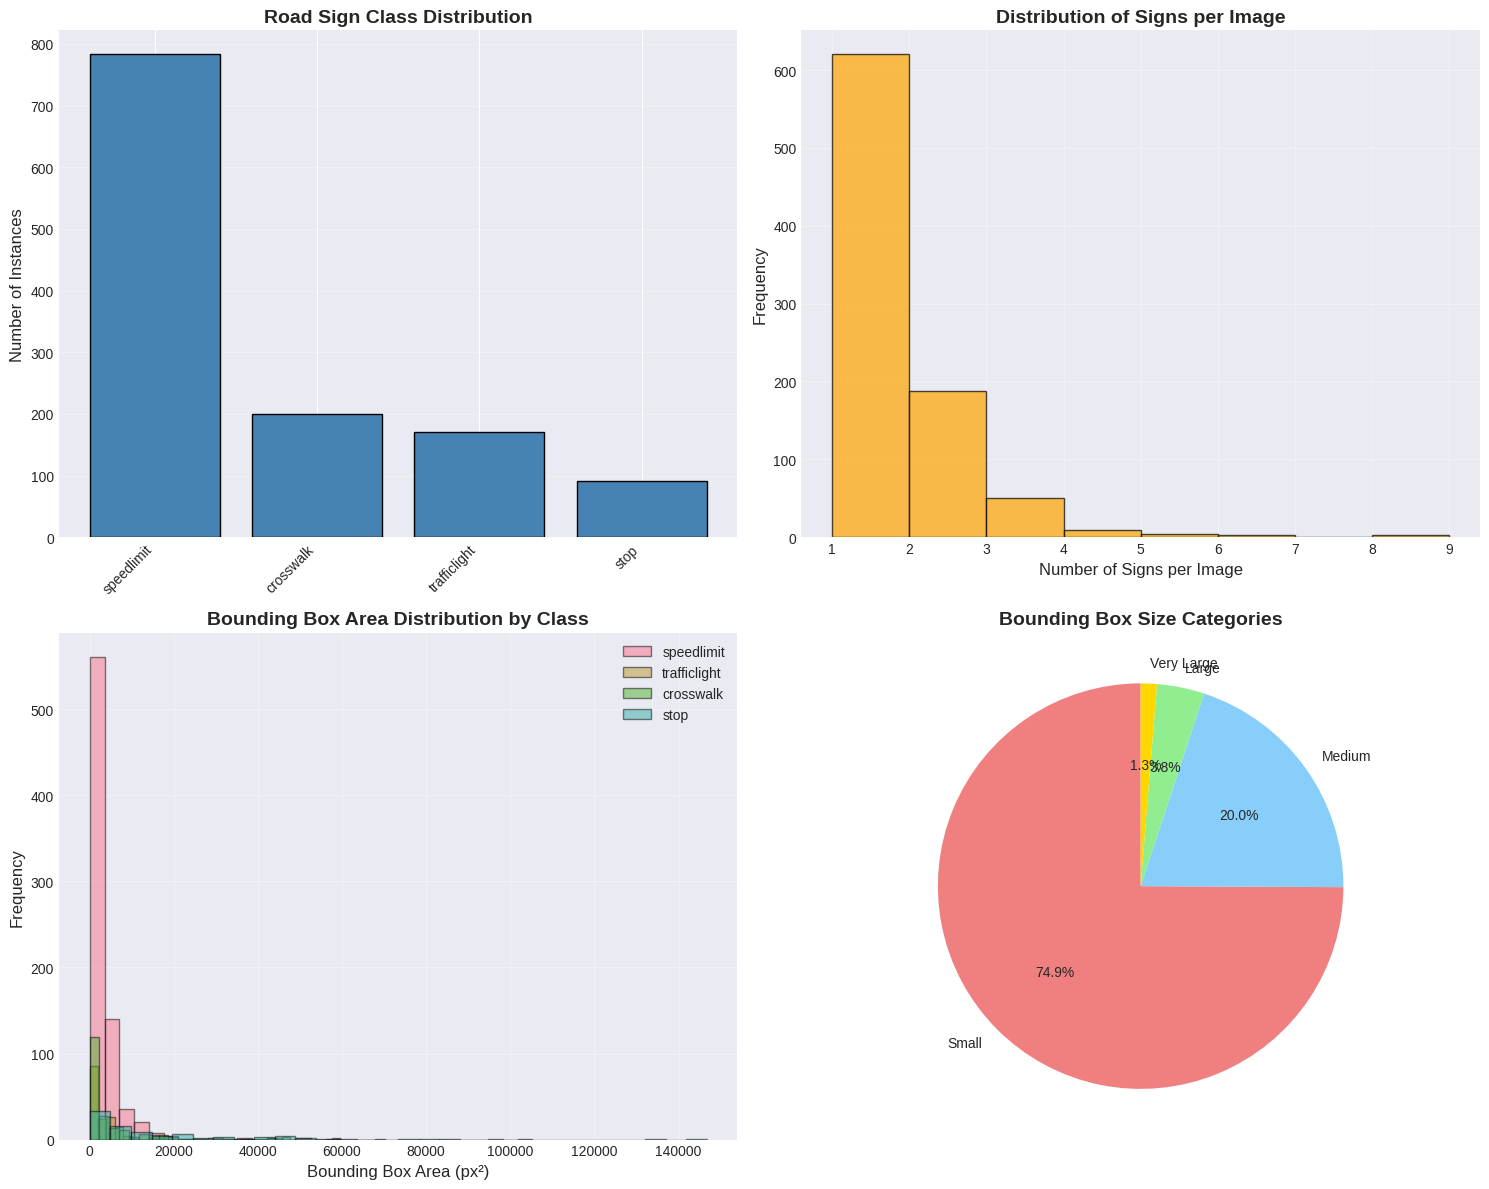

In [48]:
# Visualize road sign dataset
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Class distribution
class_counts = road_signs_df['class'].value_counts()
axes[0, 0].bar(range(len(class_counts)), class_counts.values, color='steelblue', edgecolor='black')
axes[0, 0].set_xticks(range(len(class_counts)))
axes[0, 0].set_xticklabels(class_counts.index, rotation=45, ha='right')
axes[0, 0].set_ylabel('Number of Instances', fontsize=12)
axes[0, 0].set_title('Road Sign Class Distribution', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3, axis='y')

# Signs per image distribution
axes[0, 1].hist(signs_per_image, bins=range(1, signs_per_image.max() + 2), 
                edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Number of Signs per Image', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Distribution of Signs per Image', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Bounding box area by class
for cls in road_signs_df['class'].unique():
    cls_data = road_signs_df[road_signs_df['class'] == cls]['bbox_area']
    axes[1, 0].hist(cls_data, bins=30, alpha=0.5, label=cls, edgecolor='black')
axes[1, 0].set_xlabel('Bounding Box Area (px²)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Bounding Box Area Distribution by Class', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Bounding box size category
size_cat_counts = road_signs_df['bbox_size_category'].value_counts().sort_index()
axes[1, 1].pie(size_cat_counts.values, labels=size_cat_counts.index, autopct='%1.1f%%',
               startangle=90, colors=['lightcoral', 'lightskyblue', 'lightgreen', 'gold'])
axes[1, 1].set_title('Bounding Box Size Categories', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [49]:
print("DATASET SUMMARY & RECOMMENDATIONS")

print("\n COCO Dataset Summary:")
print(f"   • Total images: {len(coco_images):,}")
print(f"   • Total captions: {len(coco_captions):,}")
print(f"   • Total object categories: {len(coco_categories)}")
print(f"   • Images with relevant assistive classes: {len(relevant_image_ids):,}")
print(f"   • Recommended subset size: 10,000-50,000 images")

print("\n Road Sign Dataset Summary:")
print(f"   • Total images: {road_signs_df['filename'].nunique():,}")
print(f"   • Total sign annotations: {len(road_signs_df):,}")
print(f"   • Sign categories: {road_signs_df['class'].nunique()}")
print(f"   • Average signs per image: {signs_per_image.mean():.2f}")

DATASET SUMMARY & RECOMMENDATIONS

 COCO Dataset Summary:
   • Total images: 123,287
   • Total captions: 616,767
   • Total object categories: 80
   • Images with relevant assistive classes: 64,516
   • Recommended subset size: 10,000-50,000 images

 Road Sign Dataset Summary:
   • Total images: 877
   • Total sign annotations: 1,244
   • Sign categories: 4
   • Average signs per image: 1.42


In [50]:
# Function to display sample images
def display_sample_images(image_ids, dataset_type='coco', n_samples=3):

    fig, axes = plt.subplots(1, n_samples, figsize=(15, 5))
    
    if dataset_type == 'coco':
        # Note: This requires actual image files to be present
        print("Sample COCO images would be displayed here")
        print("Image IDs:", image_ids[:n_samples])
    elif dataset_type == 'road_sign':
        print("Sample road sign images would be displayed here")
        print("Filenames:", road_signs_df['filename'].unique()[:n_samples])
    
    plt.tight_layout()
    plt.show()

print(" Sample visualization function created")

 Sample visualization function created


In [51]:
# Save filtered dataset information for later use
print("EXPORTING DATASET METADATA")

# Save relevant COCO image IDs
relevant_coco_subset = pd.DataFrame({
    'image_id': relevant_image_ids
})

# Merge with image info
relevant_coco_info = coco_images[coco_images['id'].isin(relevant_image_ids)].copy()

print(f"\n Relevant COCO subset: {len(relevant_coco_info)} images")
print(f" Road sign dataset: {road_signs_df['filename'].nunique()} images")
print(f"\n Data ready for model training pipeline")

# Display summary statistics
print("EDA COMPLETE - KEY METRICS")
print(f"\n1. COCO Dataset:")
print(f"   - Selected images: {len(relevant_coco_info):,}")
print(f"   - Average captions/image: 5")
print(f"   - Selected object classes: {len(ASSISTIVE_CLASSES)}")
print(f"\n2. Road Sign Dataset:")
print(f"   - Total images: {road_signs_df['filename'].nunique()}")
print(f"   - Sign categories: {list(road_signs_df['class'].unique())}")
print(f"   - Total annotations: {len(road_signs_df)}")
print(f"\n3. Combined Dataset Characteristics:")
print(f"   - Total unique classes: ~{len(ASSISTIVE_CLASSES) + road_signs_df['class'].nunique()}")
print(f"   - Recommended training approach: Two-stage or unified YOLO")
print(f"   - Modalities covered: Vision, Language (captions), Audio (TTS)")

EXPORTING DATASET METADATA

 Relevant COCO subset: 64516 images
 Road sign dataset: 877 images

 Data ready for model training pipeline
EDA COMPLETE - KEY METRICS

1. COCO Dataset:
   - Selected images: 64,516
   - Average captions/image: 5
   - Selected object classes: 24

2. Road Sign Dataset:
   - Total images: 877
   - Sign categories: ['speedlimit', 'trafficlight', 'crosswalk', 'stop']
   - Total annotations: 1244

3. Combined Dataset Characteristics:
   - Total unique classes: ~28
   - Recommended training approach: Two-stage or unified YOLO
   - Modalities covered: Vision, Language (captions), Audio (TTS)


In [52]:
OUTPUT_DIR = "/kaggle/working/assistive_vision_dataset"
YOLO_DIR = os.path.join(OUTPUT_DIR, "yolo_format")

for path in [
    os.path.join(YOLO_DIR, "images", "train"),
    os.path.join(YOLO_DIR, "images", "val"),
    os.path.join(YOLO_DIR, "labels", "train"),
    os.path.join(YOLO_DIR, "labels", "val")
]:
    os.makedirs(path, exist_ok=True)


In [53]:
ASSISTIVE_CLASSES = {
    'person': 0, 'bicycle': 1, 'car': 2, 'motorcycle': 3, 'bus': 4, 'truck': 5,
    'traffic light': 6, 'stop sign': 7, 'bench': 8, 'chair': 9, 'couch': 10,
    'potted plant': 11, 'dining table': 12, 'tv': 13, 'laptop': 14, 
    'cell phone': 15, 'book': 16, 'clock': 17, 'bottle': 18, 'cup': 19,
    'fork': 20, 'knife': 21, 'spoon': 22, 'bowl': 23
}

ROAD_SIGN_CLASSES = {'trafficlight': 24, 'stop': 25, 'speedlimit': 26, 'crosswalk': 27}
ALL_CLASSES = {**ASSISTIVE_CLASSES, **ROAD_SIGN_CLASSES}
CLASS_NAMES = list(ALL_CLASSES.keys())

coco_to_our_class = {cat['id']: ASSISTIVE_CLASSES[cat['name']] 
                     for cat in coco_instances['categories'] 
                     if cat['name'] in ASSISTIVE_CLASSES}

print(f"Total classes: {len(ALL_CLASSES)} ({len(ASSISTIVE_CLASSES)} COCO + {len(ROAD_SIGN_CLASSES)} road signs)")

Total classes: 28 (24 COCO + 4 road signs)


In [54]:
#Convert COCO to YOLO Format
def coco_to_yolo_bbox(bbox, w, h):
    x, y, bw, bh = bbox
    return [(x + bw/2)/w, (y + bh/2)/h, bw/w, bh/h]

def process_coco_to_yolo(split='train', max_images=8000):
    # Load the correct instance annotations based on split
    if split == 'train':
        instances_file = os.path.join(COCO_PATH, "annotations_trainval2014/annotations/instances_train2014.json")
    else:
        instances_file = os.path.join(COCO_PATH, "annotations_trainval2014/annotations/instances_val2014.json")
    
    with open(instances_file, 'r') as f:
        instances = json.load(f)
    
    img_to_anns = {}
    for ann in instances['annotations']:
        if ann['category_id'] in coco_to_our_class:
            img_to_anns.setdefault(ann['image_id'], []).append(ann)
    
    img_ids = list(img_to_anns.keys())[:max_images]
    img_info = {img['id']: img for img in instances['images'] if img['id'] in img_ids}
    
    count = 0
    for img_id in tqdm(img_ids, desc=f"COCO {split}"):
        if img_id not in img_info:
            continue
        
        img = img_info[img_id]
        labels = []
        
        for ann in img_to_anns[img_id]:
            class_id = coco_to_our_class[ann['category_id']]
            bbox = coco_to_yolo_bbox(ann['bbox'], img['width'], img['height'])
            labels.append([class_id] + bbox)
        
        if labels:
            label_path = os.path.join(YOLO_DIR, "labels", split, f"{Path(img['file_name']).stem}.txt")
            with open(label_path, 'w') as f:
                for lbl in labels:
                    f.write(f"{lbl[0]} {lbl[1]:.6f} {lbl[2]:.6f} {lbl[3]:.6f} {lbl[4]:.6f}\n")
            count += 1
    
    return count

coco_train_cnt = process_coco_to_yolo('train', 8000)
coco_val_cnt = process_coco_to_yolo('val', 2000)

COCO val: 100%|██████████| 2000/2000 [00:00<00:00, 8963.12it/s]


In [55]:
def process_road_signs_to_yolo():
    unique_imgs = road_signs_df['filename'].unique()
    np.random.shuffle(unique_imgs)
    split_idx = int(len(unique_imgs) * 0.8)
    splits = {'train': unique_imgs[:split_idx], 'val': unique_imgs[split_idx:]}
    
    counts = {}
    for split, imgs in splits.items():
        count = 0
        for img_name in tqdm(imgs, desc=f"Road signs {split}"):
            img_anns = road_signs_df[road_signs_df['filename'] == img_name]
            labels = []
            
            for _, row in img_anns.iterrows():
                class_id = ROAD_SIGN_CLASSES.get(row['class'], -1)
                if class_id == -1:
                    continue
                x_c = ((row['xmin'] + row['xmax']) / 2) / row['width']
                y_c = ((row['ymin'] + row['ymax']) / 2) / row['height']
                w = (row['xmax'] - row['xmin']) / row['width']
                h = (row['ymax'] - row['ymin']) / row['height']
                labels.append([class_id, x_c, y_c, w, h])
            
            if labels:
                label_path = os.path.join(YOLO_DIR, "labels", split, f"{Path(img_name).stem}.txt")
                with open(label_path, 'w') as f:
                    for lbl in labels:
                        f.write(f"{lbl[0]} {lbl[1]:.6f} {lbl[2]:.6f} {lbl[3]:.6f} {lbl[4]:.6f}\n")
                count += 1
        counts[split] = count
    
    return counts['train'], counts['val']

road_train_cnt, road_val_cnt = process_road_signs_to_yolo()

print(f"\nDataset Ready:")
print(f"Train: {coco_train_cnt + road_train_cnt} | Val: {coco_val_cnt + road_val_cnt}")

Road signs val: 100%|██████████| 176/176 [00:00<00:00, 1168.40it/s]


Dataset Ready:
Train: 8701 | Val: 2176


In [56]:
yaml_content = f"""path: {YOLO_DIR}
train: images/train
val: images/val
nc: {len(ALL_CLASSES)}
names: {{{', '.join(f'{i}: {name}' for i, name in enumerate(CLASS_NAMES))}}}
"""

yaml_path = os.path.join(YOLO_DIR, "data.yaml")
with open(yaml_path, 'w') as f:
    f.write(yaml_content)
print("done")

done


In [ ]:
from ultralytics import YOLO

os.environ["WANDB_DISABLED"] = "true"
os.environ["TORCH_LOGS"] = "+dynamo"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  

if torch.cuda.is_available():
    print(" GPU name:", torch.cuda.get_device_name(0))
    print(" GPU memory total (GB):",
          round(torch.cuda.get_device_properties(0).total_memory / 1e9, 2))

print("\n Loading YOLO model...")
model = YOLO("yolov8n.yaml")
print(" Model loaded")

print("\n Starting training...")

results = model.train(
    data=yaml_path,
    epochs=50,
    imgsz=640,

    # GPU
    batch=32,
    device=0,

    # CPU
    workers=4,        # reduced to avoid Kaggle freeze

    # RAM
    cache=True,

    # Logs & behavior
    project="results",
    name="assistive_vision",
    exist_ok=True,
    patience=20,
    plots=True,
    verbose=True,     #  force YOLO logs

    # Performance
    amp=True
)

print(" Training finished")



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

 GPU name: Tesla P100-PCIE-16GB
 GPU memory total (GB): 17.06

 Loading YOLO model...


YOLOv8n summary: 225 layers, 3157200 parameters, 3157184 gradients, 8.9 GFLOPs

New https://pypi.org/project/ultralytics/8.3.247 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/kaggle/working/assistive_vision_dataset/yolo_format/data.yaml, epochs=50, patience=20, batch=32, imgsz=640, save=True, save_period=-1, cache=True, device=0, workers=4, project=results, name=assistive_vision, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=Fals

 Model loaded

 Starting training...


YOLOv8n summary: 225 layers, 3016308 parameters, 3016292 gradients, 8.2 GFLOPs

TensorBoard: Start with 'tensorboard --logdir results/assistive_vision', view at http://localhost:6006/


<IPython.core.display.Javascript object>

In [ ]:
metrics = model.val()
print(f"mAP50: {metrics.box.map50:.4f} | mAP50-95: {metrics.box.map:.4f}")

model_path = "/kaggle/working/assistive_vision.pt"
model.save(model_path)
print(f"Model saved: {model_path}")

In [ ]:
from transformers import (Blip2Processor, Blip2ForConditionalGeneration,
                         TrOCRProcessor, VisionEncoderDecoderModel)

blip_proc = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
blip_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
)

ocr_proc = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')
ocr_model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')

if torch.cuda.is_available():
    blip_model = blip_model.to("cuda")
    ocr_model = ocr_model.to("cuda")

print("All models loaded")


In [ ]:
class AssistiveVisionSystem:
    def __init__(self, yolo_path):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.yolo = YOLO(yolo_path)
        self.blip_proc = blip_proc
        self.blip_model = blip_model
        self.ocr_proc = ocr_proc
        self.ocr_model = ocr_model
        self.class_names = CLASS_NAMES
    
    def detect(self, img_path, conf=0.25):
        results = self.yolo(img_path, conf=conf)[0]
        return [{'class': self.class_names[int(box.cls[0])], 
                 'conf': float(box.conf[0]),
                 'bbox': box.xyxy[0].tolist()} 
                for box in results.boxes]
    
    def caption(self, img_path):
        img = Image.open(img_path).convert('RGB')
        inputs = self.blip_proc(img, return_tensors="pt")
        if self.device == 'cuda':
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
        ids = self.blip_model.generate(**inputs, max_length=50)
        return self.blip_proc.batch_decode(ids, skip_special_tokens=True)[0]
    
    def ocr(self, img_path):
        try:
            img = Image.open(img_path).convert('RGB')
            pv = self.ocr_proc(img, return_tensors="pt").pixel_values
            if self.device == 'cuda':
                pv = pv.to(self.device)
            ids = self.ocr_model.generate(pv)
            text = self.ocr_proc.batch_decode(ids, skip_special_tokens=True)[0]
            return text.strip() or None
        except:
            return None
    
    def analyze(self, img_path):
        detections = self.detect(img_path)
        caption = self.caption(img_path)
        text = self.ocr(img_path)
        
        desc_parts = [f"Scene: {caption}."]
        
        if detections:
            priority = ['person', 'car', 'bicycle', 'motorcycle', 'bus', 'truck',
                       'traffic light', 'stop sign', 'crosswalk']
            pri_dets = [d for d in detections if d['class'] in priority]
            
            if pri_dets:
                objs = ', '.join([d['class'] for d in pri_dets[:5]])
                desc_parts.append(f"Important objects: {objs}.")
        
        if text:
            desc_parts.append(f"Text visible: {text}.")
        
        audio_desc = ' '.join(desc_parts)
        
        print(f"\nAnalysis: {img_path}")
        print(f"Detections: {len(detections)}")
        print(f"Caption: {caption}")
        print(f"Text: {text or 'None'}")
        print(f"Audio: {audio_desc}")
        
        return {'detections': detections, 'caption': caption, 
                'text': text, 'audio': audio_desc}

system = AssistiveVisionSystem(model_path)
print("System ready!")

In [ ]:
# Cell 11: Test System (optional)
# test_img = "/path/to/image.jpg"
# results = system.analyze(test_img)


In [ ]:
# Cell 12: TTS Integration
"""
!pip install gtts -q
from gtts import gTTS

def speak(text, output="audio.mp3"):
    gTTS(text=text, lang='en').save(output)
    return output

# audio = speak(results['audio'])
"""

print("\n Training pipeline complete!")